<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch03_CH01_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLG 시스템 구성
- NLU에서 받아온 Intent와 slot을 키로 템플릿 찾고, NLG slot채우고 가장 best template 찾기
- single turn 기반의 대화 시스템 ( Text -> NLU -> NLG -> Text)
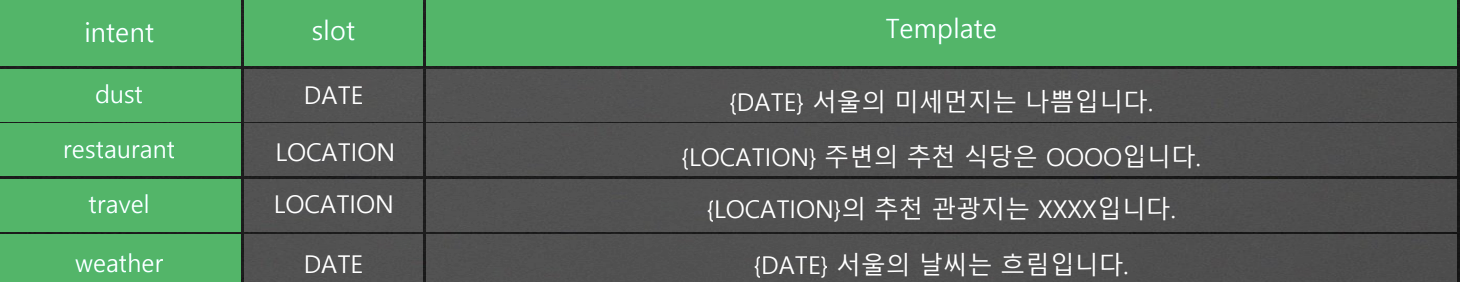

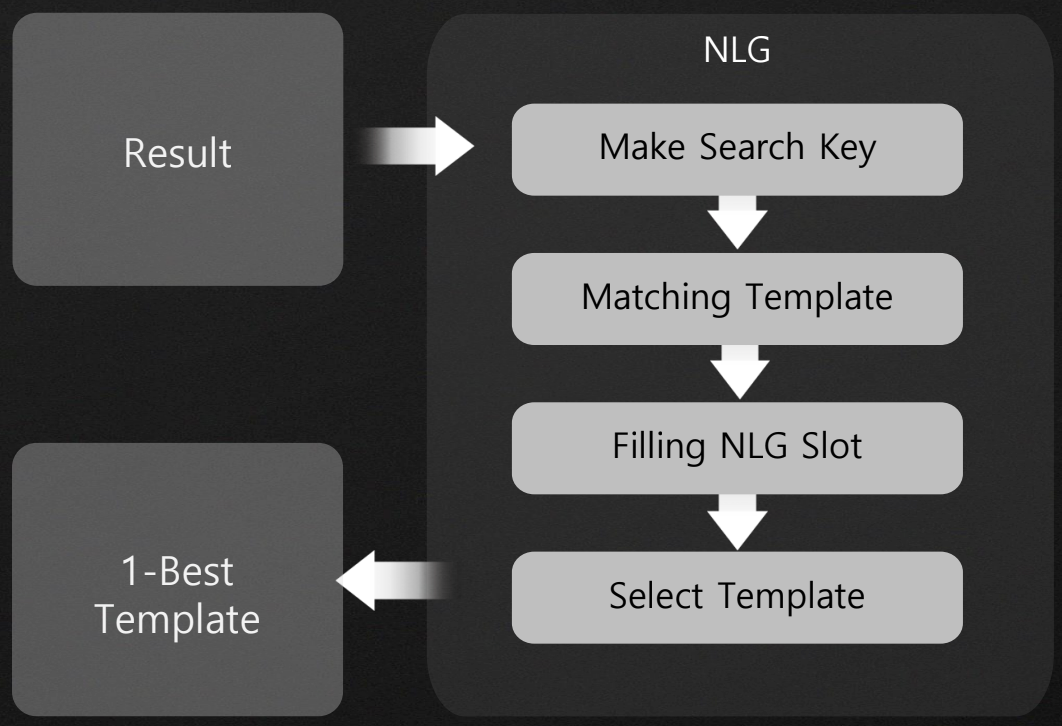

In [2]:
!pip install sentencepiece
!pip uninstall pytorch-crf
!pip install pytorch-crf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00


In [3]:
import os
import sys
import json
import random
import pandas as pd
import numpy as np
from collections import deque

%cd /content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
from src.model import BiLSTM_CRF, MakeEmbed, textCNN, DAN, EpochLogger, save
from src.dataset import Preprocessing, MakeDataset
from src.NLU import NaturalLanguageUnderstanding
%cd /root

/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
/root


In [4]:
class NLG:

    def __init__(self):
        self.template_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/search_template_dataset.csv"
        self.values = {
                    "DATE" : "",
                    "LOCATION" : "",
                    "PLACE" : "",
                    "RESTAURANT" : ""
                 }

        self.template = self.load_template()

    def load_template(self): # NLG 템플릿 로드
        template = pd.read_csv(self.template_dir)
        return template

    def search_template(self, nlu_result): # NLG 템플릿 검색
        intent, slots = self.make_search_key(nlu_result) # NLU 결과로 매칭 키 만들기
        matched_template = []
        print("")
        print("#####대화 흐름 검색 시작######")
        for data in self.template.iterrows(): # NLG 템플릿을 순차적으로 돌면서 NLU 결과와 매칭되는 템플릿 검색
            intent_flag = False
            slot_flag = False

            row = data[1]
            if(row["label"] == intent): # intent 매칭
                intent_flag = True
            if(isinstance(row.get("slot"), str)): # slot 매칭
                template_slots = sorted(row["slot"].split("^"))
                key_slots = sorted(slots.split("^"))
                if(template_slots == key_slots):
                    slot_flag = True
            elif(slots == ""): # slot 없는 경우
                slot_flag = True

            if(intent_flag and slot_flag): # intent, slot 둘다 매칭되는 경우 검색 성공
                print("#############매칭#############")
                matched_template.append(row["template"])
        print("#####대화 흐름 검색 종료######")
        print("")
        return matched_template

    def make_search_key(self, nlu_result): # NLU 결과로 매칭 키 만들기
        intent = nlu_result.get("INTENT")

        keys = set()
        for name_value in nlu_result.get("SLOT"):
            slot_name = name_value.split("^")[0]
            slot_value = name_value.split("^")[1]
            keys.add(slot_name)
            self.values[slot_name] = slot_value

        slots = "^".join(keys)
        return intent, slots # intent, slot1^slot2...

    def replace_slot(self, flag, key, template): # SLOT 채우기
        value = self.values.get(key)
        key = "{"+key+"}"
        if(value != ""):
            template = template.replace(key,value)
        else:
            template = ""
        flag = not flag
        return flag, template

    def filling_NLG_slot(self, templates):
        filling_templates = []

        for template in templates:
            # 템플릿에 해당 SLOT값이 있는지 확인
            date_index = template.find("{DATE}")
            location_index = template.find("{LOCATION}")
            place_index = template.find("{PLACE}")
            restraurant_index = template.find("{RESTAURANT}")

            date_flag = date_index == -1
            location_flag = location_index == -1
            place_flag = place_index == -1
            restraurant_flag = restraurant_index == -1

            # 채워야하는 SLOT을 채우고 채워졌는지 확인
            # 모두 채울때 까지 반복
            cnt = 0
            while(not (date_flag and location_flag and place_flag and restraurant_flag)):
                print("before : "+template)
                if(not date_flag):
                    key = "DATE"
                    date_flag, template = self.replace_slot(date_flag, key, template)

                if(not location_flag):
                    key = "LOCATION"
                    location_flag, template = self.replace_slot(location_flag, key, template)

                if(not place_flag):
                    key = "PLACE"
                    date_flag, template = self.replace_slot(place_flag, key, template)

                if(not restraurant_flag):
                    key = "RESTAURANT"
                    location_flag, template = self.replace_slot(restraurant_flag, key, template)
                print("after : "+template)
                filling_templates.append(template)

        return filling_templates

    def select_template(self, templates): # 만약 N개의 템플릿이 매칭될경우 랜덤하게 한가지 출력
        template_size = len(templates)
        if(template_size == 1):
            template = templates[0]
        elif(template_size > 1):
            template = random.choice(templates)
        else:
            template = ""
        return template

    def run_search(self, nlu_result):
        print("#######템플릿 매칭 시작#######")
        templates = self.search_template(nlu_result) # NLU 결과를 통한 탬플릿 찾기
        for i, template in enumerate(templates):
            print(str(i)+". template : "+template)
        print("#######템플릿 매칭 종료#######")
        print("")
        print("######템플릿 채우기 시작######")
        templates = self.filling_NLG_slot(templates) # 매칭된 템플릿 SLOT 채우기
        print("######템플릿 채우기 종료######")
        print("")
        template = self.select_template(templates) # N개의 템플릿이 매칭될경우 선택하는 로직
        if(template == ""):
            template = "죄송합니다. 다시 말해주세요."
        return template



In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
intent_pretrain_path = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_intent_clsf_model/intent_clsf_97.217_steps_33.pt"
entity_pretrain_path = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_entity_recog_model/entity_recog_97.192_steps_7.pt"
ood_pretrain_path = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_ood_clsf_model/ood_clsf_99.724_steps_5.pt"
NLU = NaturalLanguageUnderstanding()

NLU.model_load(intent_pretrain_path, entity_pretrain_path,ood_pretrain_path)

NLG = NLG()

In [7]:
query = "오늘 날씨 알려줘"

print("******************************")
print("********언어 이해 시작********")
NLU_result = NLU.run(query)
print("********언어 이해 결과********")
print("******************************")
print("")
print("******************************")
print("********대화 관리 시작********")
system_response = NLG.run_search(NLU_result)
print("********대화 관리 종료********")
print("******************************")
print("")
print("사용자 발화 : " + query)
print("시스템 응답 : " + system_response)

******************************
********언어 이해 시작********
********언어 이해 결과********
******************************

******************************
********대화 관리 시작********
#######템플릿 매칭 시작#######

#####대화 흐름 검색 시작######
#############매칭#############
#####대화 흐름 검색 종료######

0. template : {DATE} 서울의 날씨는 흐림입니다.
#######템플릿 매칭 종료#######

######템플릿 채우기 시작######
before : {DATE} 서울의 날씨는 흐림입니다.
after : 오늘 서울의 날씨는 흐림입니다.
######템플릿 채우기 종료######

********대화 관리 종료********
******************************

사용자 발화 : 오늘 날씨 알려줘
시스템 응답 : 오늘 서울의 날씨는 흐림입니다.


In [12]:
query = "남양주시 맛집 알려줘"

print("******************************")
print("********언어 이해 시작********")
NLU_result = NLU.run(query)
print("********언어 이해 결과********")
print("******************************")
print("")
print("******************************")
print("********대화 관리 시작********")
system_response = NLG.run_search(NLU_result)
print("********대화 관리 종료********")
print("******************************")
print("")
print("사용자 발화 : " + query)
print("시스템 응답 : " + system_response)

******************************
********언어 이해 시작********
********언어 이해 결과********
******************************

******************************
********대화 관리 시작********
#######템플릿 매칭 시작#######

#####대화 흐름 검색 시작######
#############매칭#############
#####대화 흐름 검색 종료######

0. template : {LOCATION} 주변의 추천 식당은 OOOO입니다.
#######템플릿 매칭 종료#######

######템플릿 채우기 시작######
before : {LOCATION} 주변의 추천 식당은 OOOO입니다.
after : 남양주시 주변의 추천 식당은 OOOO입니다.
######템플릿 채우기 종료######

********대화 관리 종료********
******************************

사용자 발화 : 남양주시 맛집 알려줘
시스템 응답 : 남양주시 주변의 추천 식당은 OOOO입니다.
